#### **1) Libraries**

In [1]:
# Don't forget to restart
# !pip install -U tensorflow_probability -q
!pip install ipdb -q

     |████████████████████████████████| 788kB 6.1MB/s 
     |████████████████████████████████| 368kB 10.3MB/s 
ERROR: jupyter-console 5.2.0 has requirement prompt-toolkit<2.0.0,>=1.0.0, but you'll have prompt-toolkit 3.0.18 which is incompatible.
ERROR: google-colab 1.0.0 has requirement ipython~=5.5.0, but you'll have ipython 7.22.0 which is incompatible.


In [2]:
from IPython import display

import ipdb
import glob
import imageio
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import numpy as np
import PIL
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import time
from tqdm import tqdm

from tensorflow import keras
from tensorflow.keras.layers import Input, InputLayer, Lambda, Reshape, Dropout, \
                                    Flatten, Dense, Conv2D, Conv2DTranspose


In [3]:
# pip list | grep tensorflow

If using Google Colab, save in your Google Drive.

In [4]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


#### **2) Extract Data**

##### **2a) MNIST Data**

In [5]:
(mn_train_images, _), (mn_test_images, _) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [6]:
def preprocess_images(images, image_size, batch_size, nn_type):
    if nn_type == 'conv':
        images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
    else:
        images = images.reshape((images.shape[0], -1)) / 255.
    images = np.where(images > .5, 1.0, 0.0).astype('float32')
    return (tf.data.Dataset.from_tensor_slices(images)
            .shuffle(image_size).batch(batch_size))

In [7]:
train_size = 60000
test_size = 10000
batch_size = 32  # Also use this batch_size for Model Train 

In [8]:
mn_train_images.shape, mn_test_images.shape

((60000, 28, 28), (10000, 28, 28))

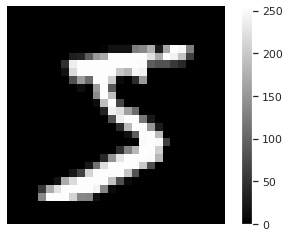

In [9]:
plt.figure()
plt.imshow(mn_train_images[0], cmap='gray')
# plt.title('corresponding image label {}'.format(label))
plt.colorbar()
plt.grid(False)
plt.axis('off')
plt.show();

In [10]:
# Use CNN
mn_train_dataset = preprocess_images(mn_train_images, train_size, batch_size, 'conv')
mn_test_dataset = preprocess_images(mn_test_images, test_size, batch_size, 'conv')
# Use Dense
# train_dataset = preprocess_images(train_images, train_size, batch_size, 'dense')
# test_dataset = preprocess_images(test_images, test_size, batch_size, 'dense')

In [11]:
type(mn_train_dataset)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [12]:
mn_train_dataset, mn_test_dataset

(<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>,
 <BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>)

In [62]:
# for elem in tqdm(mn_train_dataset):
#     ipdb.set_trace()
#     pass

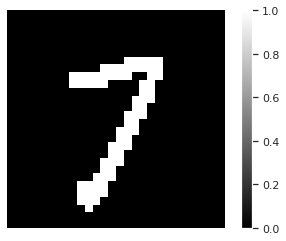

In [13]:
for train_batch in mn_train_dataset.take(1):
    image = train_batch[0].numpy()
image = np.squeeze(image, axis=2)

plt.figure()
plt.imshow(image, cmap='gray')
# plt.title('corresponding image label {}'.format(label))
plt.colorbar()
plt.grid(False)
plt.axis('off')
plt.show();

##### **2b) Oxflower Data**

In [14]:
dataset, dataset_info = tfds.load('oxford_flowers102', with_info=True, as_supervised=True)

Shuffling and writing examples to /root/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteUNKNJD/oxford_flowers102-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteUNKNJD/oxford_flowers102-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteUNKNJD/oxford_flowers102-validation.tfrecord


Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


In [15]:
training_set, test_set, validation_set = dataset['train'], dataset['test'], dataset['validation']

In [16]:
type(training_set)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

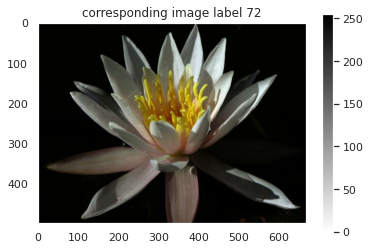

In [17]:
# TODO: Plot 1 image from the training set. Set the title 
# of the plot to the corresponding image label. 
for image, label in training_set.take(1):
    break
image = image.numpy()
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.title('corresponding image label {}'.format(label))
plt.colorbar()
plt.grid(False)
plt.show()

In [18]:
image.shape

(500, 667, 3)

In [19]:
# TODO: Get the number of examples in each set from the dataset info.
num_training_examples = 0
num_validation_examples = 0
num_test_examples = 0

for example in training_set:
  num_training_examples += 1

for example in validation_set:
  num_validation_examples += 1

for example in test_set:
  num_test_examples += 1

print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {}'.format(num_validation_examples))
print('Total Number of Test Images: {} \n'.format(num_test_examples))
# TODO: Get the number of classes in the dataset from the dataset info.
num_classes = dataset_info.features['label'].num_classes
print('Total Number of Classes: {}'.format(num_classes))

Total Number of Training Images: 1020
Total Number of Validation Images: 1020
Total Number of Test Images: 6149 

Total Number of Classes: 102


In [20]:
# TODO: Create a pipeline for each set.
IMAGE_RES = 224
BATCH_SIZE = 32

def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

In [21]:
ox_train_dataset = training_set.cache().shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
ox_test_dataset = test_set.cache().map(format_image).batch(BATCH_SIZE).prefetch(1)
ox_val_dataset = validation_set.cache().map(format_image).batch(BATCH_SIZE).prefetch(1)

In [22]:
ox_train_dataset, ox_test_dataset

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

In [23]:
# import tflearn.datasets.oxflower17 as oxflower17

In [24]:
# X, Y = oxflower17.load_data(one_hot=True)

In [25]:
# X.shape, Y.shape

In [26]:
# cutoff = 200
# ox_train_images, ox_test_images = X[:-cutoff], X[-cutoff:]

In [27]:
# ox_train_images.shape, ox_test_images.shape

In [28]:
# def preprocess_images(images, image_size, batch_size, nn_type):
#     if nn_type == 'conv':
#         images = images.reshape((images.shape[0], 224, 224, 3)) / 255.
#     else:
#         images = images.reshape((images.shape[0], -1)) / 255.
#     images = np.where(images > .5, 1.0, 0.0).astype('float32')
#     return (tf.data.Dataset.from_tensor_slices(images)
#             .shuffle(image_size).batch(batch_size))

In [29]:
# Use CNN
# ox_train_dataset = preprocess_images(ox_train_images, train_size, batch_size, 'conv')
# ox_test_dataset = preprocess_images(ox_test_images, test_size, batch_size, 'conv')

In [30]:
# print(train_dataset), print(test_dataset)

#### **3) Model Class**

Credit: 

In [31]:
class Sampler_Z(keras.layers.Layer):

    def call(self, inputs):
        mu, rho = inputs
        sd = tf.math.log(1+tf.math.exp(rho))
        batch_size = tf.shape(mu)[0]
        z_dim = tf.shape(mu)[1]
        z_sample = mu + sd * tf.random.normal(shape=(batch_size, z_dim))
        return z_sample, sd

In [32]:
class Encoder_Z(keras.layers.Layer):

    def __init__(self, z_dim, n_filter_base, name="encoder", **kwargs):
        super(Encoder_Z, self).__init__(name=name, **kwargs)
        # self.x_dim = (28, 28, 1)
        self.conv_layer_1 = Conv2D(filters=n_filter_base, kernel_size=3,
                                   strides=(2,2), padding='valid', activation='relu'
                                   )
        self.conv_layer_2 = Conv2D(filters=n_filter_base*2, kernel_size=3,
                                   strides=(2,2), padding='valid', activation='relu'
                                   )
        self.flatten_layer = Flatten()
        # No activation
        self.dense_mean = Dense(z_dim, activation=None, name='z_mean')
        self.dense_raw_stddev = Dense(z_dim, activation=None,
                                      name='z_raw_stddev'
                                      )
        self.sampler_z = Sampler_Z()

    # Functional
    def call(self, x_input):
        z = self.conv_layer_1(x_input)
        z = self.conv_layer_2(z)
        z = self.flatten_layer(z)
        mu = self.dense_mean(z)
        rho = self.dense_raw_stddev(z)
        z_sample, sd = self.sampler_z((mu,rho))
        return z_sample, mu, sd

In [33]:
class Decoder_X(keras.layers.Layer):

    def __init__(self, z_dim, n_filter_base, name="decoder", **kwargs):
        super(Decoder_X, self).__init__(name=name, **kwargs)
        self.z_dim = z_dim
        self.dense_z_input = Dense(7*7*32, activation=None)
        self.reshape_layer = Reshape((7,7,32))
        self.conv_transpose_layer_1 = Conv2DTranspose(filters=n_filter_base*2, kernel_size=3,
                                                      strides=2, padding='same', activation='relu'
                                                      )
        self.conv_transpose_layer_2 = Conv2DTranspose(filters=n_filter_base, kernel_size=3,
                                                      strides=2, padding='same', activation='relu'
                                                      )
        self.conv_transpose_layer_3 = Conv2DTranspose(filters=1, kernel_size=3,
                                                      strides=1, padding='same'
                                                      )

    # Functional
    def call(self, z):
        x_output = self.dense_z_input(z)
        x_output = self.reshape_layer(x_output)
        x_output = self.conv_transpose_layer_1(x_output)
        x_output = self.conv_transpose_layer_2(x_output)
        x_output = self.conv_transpose_layer_3(x_output)
        return x_output

In [34]:
class VAEModel(keras.Model):
    """Variational Autoencoder base model."""

    def __init__(self, z_dim, n_filter_base=24, kl_weight=1, name="autoencoder", **kwargs):
        super(VAEModel, self).__init__(name=name, **kwargs)
        # self.x_dim = (28, 28, 1)
        self.learning_rate = learning_rate
        self.encoder = Encoder_Z(z_dim, n_filter_base)
        self.decoder = Decoder_X(z_dim, n_filter_base)
        self.kl_weight = kl_weight

    # def encode_and_decode(self, x_input):
    def call(self, x_input):
        z_sample, mu, sd = self.encoder(x_input)
        x_recons_logits = self.decoder(z_sample)
        
        kl_divergence = - 0.5 * tf.math.reduce_sum(1 + \
                                                   tf.math.log(tf.math.square(sd)) - \
                                                   tf.math.square(mu) - \
                                                   tf.math.square(sd), axis=1
                                                   )
        kl_divergence = tf.math.reduce_mean(kl_divergence)
        # self.add_loss(lambda: self.kl_weight * kl_divergence)
        self.add_loss(self.kl_weight * kl_divergence)
        return x_recons_logits


In [77]:
class VAE:
    """Variational Autoencoder wrapper."""
    def __init__(self, z_dim, n_filter_base, learning_rate=0.0005):
        self.optimizer = keras.optimizers.Adam(learning_rate)
        self.loss_metric = keras.metrics.Mean()
        self.model = VAEModel(z_dim, n_filter_base)

    def train(self, train_dataset, test_dataset, n_epoch=100, batch_size=0, 
              show_display=True, display_sample=False, n_display=16):
        # Pick a sample of the test set for generating output images
        assert batch_size >= n_display  # num_examples_to_generate
        # ipdb.set_trace()
        for test_batch in test_dataset.take(1):
            test_sample = test_batch[0:n_display, :, :, :]

        for epoch in range(1, n_epoch + 1):
            start_time = time.time()
            for train_x in tqdm(train_dataset):
                self.train_step(train_x)
            end_time = time.time()

            loss = tf.keras.metrics.Mean()
            for test_x in test_dataset:
                loss(self._compute_loss(test_x))
            elbo = -loss.result()
            display.clear_output(wait=False)
            print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
                  .format(epoch, elbo, end_time - start_time)
                  )
            if show_display:
                sample_images = self._generate_images(test_sample, display_sample, n_display)
                self._display_images(sample_images, epoch)

    @tf.function
    def train_step(self, x):
        """Executes one training step and returns the loss.

        This function computes the loss and gradients, and uses the latter to
        update the model's parameters.
        """
        with tf.GradientTape() as tape:
            neg_log_lik = self._compute_loss(x)
            # kl_loss = model.losses[-1]
            kl_loss = tf.math.reduce_sum(self.model.losses)  # vae.losses is a list
            total_vae_loss = neg_log_lik + kl_loss
        gradients = tape.gradient(total_vae_loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
        self.loss_metric(total_vae_loss)

    # vae loss function -- only the negative log-likelihood part, 
    # since we use add_loss for the KL divergence part
    def _compute_loss(self, x_true):
        # x_recons_logits = model.encode_and_decode(x_true)
        x_recons_logits = self.model(x_true)
        # compute cross entropy loss for each dimension of every datapoint
        raw_cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
        labels=x_true, logits=x_recons_logits)
        neg_log_likelihood = tf.math.reduce_sum(raw_cross_entropy, axis=[1, 2, 3])
        return tf.math.reduce_mean(neg_log_likelihood)

    def _generate_images(self, test_images, display_sample=False, n_display=16, latent_dim=2):
        if display_sample:
            z_sample = tf.random.normal(shape=(n_display, latent_dim))
            x_recons_logits = self.model.decoder(z_sample)
        else: 
            x_recons_logits = self.model(test_images)
        decoder_sample_images = tf.math.sigmoid(x_recons_logits)
        return decoder_sample_images

    def _display_images(self, images, epoch):
        fig = plt.figure(figsize=(4, 4))
        for i in range(images.shape[0]):
            plt.subplot(4, 4, i + 1)
            plt.imshow(images[i, :, :, 0], cmap='gray')
            plt.axis('off')

        # tight_layout minimizes the overlap between 2 sub-plots
        plt.savefig(f'image_at_epoch_{epoch:04d}.png')
        plt.show();


#### **4) Models Train**

In [78]:
# vae init params
z_dim = 4  # latent dim, set the dimensionality of the latent space to a plane for visualization later
n_filter_base = 32  # number of base filters in the CNN (a lot of filters?)
learning_rate = 0.0001  # uses for the internal Adam opt

# vae.train params
n_epoch = 10  # number of epochs
batch_size = 32
show_display = True
display_sample = False
n_display = 16  # number of example outputs to generate

In [79]:
z_dim, n_filter_base, learning_rate

(4, 32, 0.0001)

In [80]:
vae = VAE(z_dim, n_filter_base, learning_rate)

In [81]:
mn_train_dataset, mn_test_dataset

(<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>,
 <BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>)

In [82]:
n_epoch, batch_size, show_display, display_sample, n_display

(10, 32, True, False, 16)

Epoch: 10, Test set ELBO: -120.43299102783203, time elapse for current epoch: 7.307980060577393


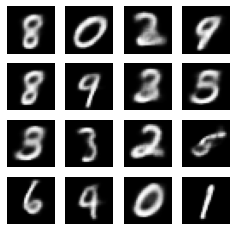

In [83]:
vae.train(mn_train_dataset, mn_test_dataset, n_epoch, batch_size, 
          show_display, display_sample, n_display
          )